COMP5930M Scientific Computation - Tutorial 7  \\
Example of a 2-D PDE

A nonlinear Laplace equation is: find $u(x,y)$ s.t.

$$
  -\nu \left( \frac{\partial^2 u}{\partial x^2} + \frac{\partial^2 u}{\partial y^2} \right) \ = \ f(u)
$$

defined in a domain $(x,y) \in \Omega \subset \mathbb{R}^2$ (here we use the unit square, $\Omega = (0,1)\times(0,1)$ for simplicity) with suitable  boundary conditions  e.g.

$$
u(x,y) = u_0(x,y) \textrm{ for all } (x,y) \in \partial \Omega.
$$

We will need our previous implementation of Newton's method for systems:

In [20]:
import scipy as sp
import numpy as np
from scipy.sparse.linalg import norm

def myNewtonSys(fnon, jac, x0, tol, maxk, *fnonargs):
    # fnon     - name of the nonlinear function f(x)
    # jac      - name of the Jacobian function J(x)
    # x0       - initial guess for the solution x0
    # tol      - stopping tolerance for Newton's iteration
    # maxk     - maximum number of Newton iterations before stopping
    # fnonargs - optional arguments that will be passed to the nonlinear function (useful for additional function parameters)

    k = 0
    x = x0

    F = eval(fnon)(x,*fnonargs)
    Fsize = F.get_shape()
    n = Fsize[0]

    normF = (F.data ** 2).sum()

    print(' k    f(xk)')

    # Main Newton loop
    while (normF > tol and k <= maxk):
        # Evaluate Jacobian matrix
        J = eval(jac)(x,n,fnon,F,*fnonargs)

        # Take Newton step by solving the tangent problem
        # (we will use the dense linear solver from NumPy for now...)
        delta = np.linalg.solve(J.toarray(),F.toarray())
        x = x - delta

        F = eval(fnon)(x,*fnonargs)
        normF = (F.data ** 2).sum()

        print('{0:2.0f}  {1:2.2e}'.format(k, normF))
        k += 1

    if (k >= maxk):
        print('Not converged')
    else:
        return x

The first step is to discretise the Laplacian operator
$\frac{\partial^2 u}{\partial x^2} + \frac{\partial^2 u}{\partial y^2} =: \triangle u$ as

$$
  \triangle u  \approx   \frac{u(x_{i+1}, y_j)+u(x_{i}, y_{j+1})-4 u(x_i,y_j) + u(x_{i-1},y_j)+u(x_{i},y_{j-1})}{h^2}    
$$

This can be visualised using a finite-difference stencil that represents the pattern of coefficients that each equation $\triangle u(x_i,y_j)$ contributes to the system matrix:

In [21]:
import scipy as sp
import numpy as np

def laplacianMatrix( nu, n ):

  # Allocate space for the matrix -(d^2u/dx^2 + d^2u/dy^2)

  # We will use the SciPy sparse matrix implementations for this, namely the
  # compressed sparse column -format (CSC). This is mostly compatible with
  # NumPy arrays but uses less memory and is computationally more efficient,
  # provided we use sparse linear algebra to solve the tangent problem.

  N = n**2

  # We use a list-of-lists format for more efficient assembly
  A = sp.sparse.lil_array((N, N), dtype=np.float64)
  h = 1. / (n-1);

  # Pass through all grid points and apply local stencil
  #
  #    -1
  # -1  4 -1
  #    -1
  #
  # for the 2D Laplacian operator L = -(d^2u/dx^2 +  d^2u/dy^2)

  stencil = np.array([4., -1., -1., -1., -1.]) / h**2

  # Loop over each internal node in the grid, i,j = 1,2,...,n-2
  for i in range(1,n-1):
    for j in range(1,n-1):
      # Find k-indices of the four neighbouring nodes
      localStencilIndices = np.array([indexFD(i,j,n), indexFD(i+1,j,n), indexFD(i-1,j,n), indexFD(i,j+1,n), indexFD(i,j-1,n)])

      # Add the local stencil for node (x_i,y_j) to the matrix
      currentRow = indexFD(i,j,n)
      for m in range (0,5):
        A[currentRow, localStencilIndices[m]] = A[currentRow, localStencilIndices[m]] + stencil[m]

  # After the matrix A has been assembled, we convert it to the column-major format
  # for more efficient computations
  A = A.tocsc()

  return (A * nu)

We make use of a helper function that takes the two-dimensional index $(i,j)$ and returns the one-dimensional index $k(i,j)$ in the long solution vector.

In [22]:
# Finds the index k = 0,1,2,...,N-1 in the vector corresponding to the grid
# point (x_i, y_j) where i,j = 0,1,2,...,n-1

def indexFD(i, j, n):
  return ( i*n + j )

To apply boundary conditions, we will create a helper function that finds indices to the nodes that are on the boundary of the domain (exterior nodes) and nodes that are not (interior nodes):

In [23]:
import numpy as np

def boundaryConditions(n):

  extNodes = []

  # Find nodes at the boundary of the square
  for j in range(0,n):
    extNodes.append( indexFD(j,0,n) )
    extNodes.append( indexFD(j,n-1,n) )
    extNodes.append( indexFD(0,j,n) )
    extNodes.append( indexFD(n-1,j,n) )

  extNodes = np.unique(extNodes)
  intNodes = np.setdiff1d(np.arange(0,n**2), extNodes);

  return intNodes, extNodes

To simplify the Newton implementation, we will use the finite-difference Jacobian algorithm:

In [24]:
import scipy as sp
import copy

def fdJacobian(x,n,fnon,F0,*fnonargs):
  # We replace the dense NumPy array with a sparse SciPy matrix
  # (list-of-lists format is used for assembly)

  J = sp.sparse.lil_array((n, n), dtype=np.float64)
  h = 10e-8

  for k in range(0,n):
    xb = copy.deepcopy(x)
    xb[k,0] = xb[k,0] + h

    F = eval(fnon)(xb,*fnonargs)

    for i in range(0,n):
      J[i,k] = (F[i,0] - F0[i,0]) / h

  # Return the Jacobian in column-major sparse format
  return J.tocsc()

Once the matrix $A$ has been assembled, we can compute ${\bf F}({\bf u})$ for the nonlinear Laplace problem:
$$
{\bf F}({\bf u}) =
\left\{
\begin{aligned}
 A {\bf u}_{int} - {\bf f}({\bf u}_{int}) &= {\bf 0} \\
{\bf u}_{bdary}   &= {\bf 0}
\end{aligned}
\right.
$$
where ${\bf u}_{int}$ are the values in the interior nodes and ${\bf u}_{bdary}$ the values in the boundary nodes. The Jacobian matrix now becomes
$$
{\bf J}(\begin{bmatrix}{\bf u}_{int} \\ {\bf u}_{bdary}\end{bmatrix}) := \begin{bmatrix} A - \frac{\partial {\bf f}}{\partial {\bf u}} & 0 \\
0 & I
\end{bmatrix}.
$$

In [25]:
import math

def laplaceF( u, A, n ):

  N = n**2
  f = sp.sparse.lil_array((N, 1), dtype=np.float64)

  # Find the internal nodes and the boundary nodes
  intNodes, extNodes  = boundaryConditions(n)

  # Evaluate the nonlinear Laplacian equation (make sure to use sparse matrix-vector multiplication)

  Au = A[intNodes,:] @ u # Sparse matrix-vector multiplication
  Fu = sp.sparse.lil_array((N, 1), dtype=np.float64)

  # Evaluate the nonlinear function F(u) = (u - 1)^2
  for k in intNodes:
    Fu[k] = (u[k,0] - 1)**2

  f[intNodes] = Au - Fu[intNodes]

  # Set value of U at boundary nodes (this imposes u=0 at the boundary)
  f[extNodes] = u[extNodes]

  return f.tocsc()

Now we have everything we need to introduce the main nonlinear PDE solver:

In [26]:
import scipy as sp
import matplotlib.pyplot as plt
import numpy as np
import time

def laplacianSolver(nu, h):

  n = int(1./h + 1)  # dimension of spatial mesh in each dimension
  N = n**2      # total number of grid points

  # Initial guess for Newton is the zero vector
  u0 = sp.sparse.csc_array( (N,1), dtype=np.float64 )

  # Assemble the Laplacian matrix
  A = laplacianMatrix(nu, n)

  # We plot the sparsity pattern of the matrix A to check that it has been
  # correctly assembled.
  fig = plt.figure()
  ax = fig.add_subplot(111)
  cax = ax.matshow(A.toarray(), vmin=-4./h*nu, vmax=4./h*nu, cmap='coolwarm')
  plt.title("Sparsity pattern")
  fig.colorbar(cax)
  plt.show()

  # Newton iteration to solve nonlinear PDE
  u = myNewtonSys( "laplaceF", "fdJacobian", u0, 1e-6, 100, A, n )

  return u

Let's solve the PDE now, first visualising the sparsity pattern (non-zero elements) of the Laplacian matrix $A$:

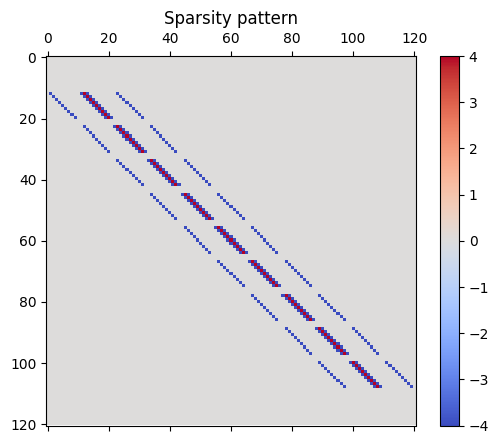

<ipython-input-20-58d2a0f5913a>:17: DeprecationWarning: `get_shape` is deprecated and will be removed in v1.13.0; use `X.shape` instead.
  Fsize = F.get_shape()
/usr/local/lib/python3.10/dist-packages/scipy/sparse/_index.py:100: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


 k    f(xk)
 0  2.96e-01
 1  1.54e-05
 2  4.44e-14


In [27]:
h = 0.1
sol = laplacianSolver(0.1, h)

The sparsity pattern presented here doesn't include the nodal values $u_{i,j}$ on the boundary where either $i=1,i=n,j=1$ or $j=n$. These values are set separately when we build the Jacobian matrix for the full nonlinear system.

Next we will visualise the 3D surface of the solution $u(x,y)$:

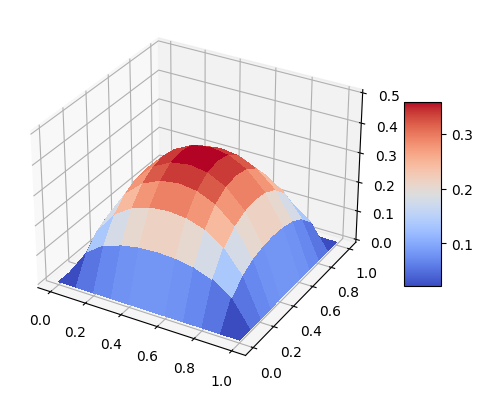

In [28]:
import matplotlib.pyplot as plt
import numpy as np

from matplotlib import cm
from matplotlib.ticker import LinearLocator

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

# Make data.
X = np.arange(0., 1.+h, h)
Y = np.arange(0., 1.+h, h)
X, Y = np.meshgrid(X, Y)
Z = sol.reshape(int(1./h+1),int(1./h+1))

# Plot the surface.
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

# Customize the z axis.
ax.set_zlim(0.0, 0.5)


# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

The solution is equal to zero at the boundary, as prescribed by our boundary conditions. The values inside the unit square depend on our source function $f(u)$. By refining the grid we can obtain more accurate solutions, at the cost of computational time.